In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def higher_order_regression(data, m):
    """
    Perform polynomial regression of degree m on the input data.

    Parameters:
    data (pd.DataFrame): A pandas DataFrame containing 'x' and 'y'.
    m (int): The degree of the polynomial to fit.

    Returns:
    np.ndarray: Coefficients (β_0, β_1, ..., β_m) of the polynomial.
    """
    
    # Extract x and y from the DataFrame
    X = data['x'].values
    Y = data['y'].values

    # Create the polynomial feature matrix for degree m
    def polynomial_features(X, degree):
        X_poly = np.ones((X.shape[0], degree + 1))  # The first column is all ones for β0 (intercept)
        for d in range(1, degree + 1):
            X_poly[:, d] = X ** d
        return X_poly
    
    # Get the design matrix X for degree m
    X_poly = polynomial_features(X, m)
    
    # Solve for beta using the normal equation: β = (X^T * X)^(-1) * X^T * Y
    XTX = np.dot(X_poly.T, X_poly)
    XTY = np.dot(X_poly.T, Y)
    
    # Solve for beta coefficients using numpy's linear algebra solver
    beta_hat = np.linalg.solve(XTX, XTY)
    
    return beta_hat

   Degree  R2_Train    R2_Val
0       1  0.730635  0.758979
1       2  0.764460  0.809192
2       3  0.840815  0.847949
3       4  0.901346  0.900385
4       5  0.905299  0.909382
5       6  0.905490  0.908907
6       7  0.905522  0.908440
7       8  0.905535  0.908410
8       9  0.906713  0.902612
9      10  0.906727  0.902806

Best degree based on validation R2: 5


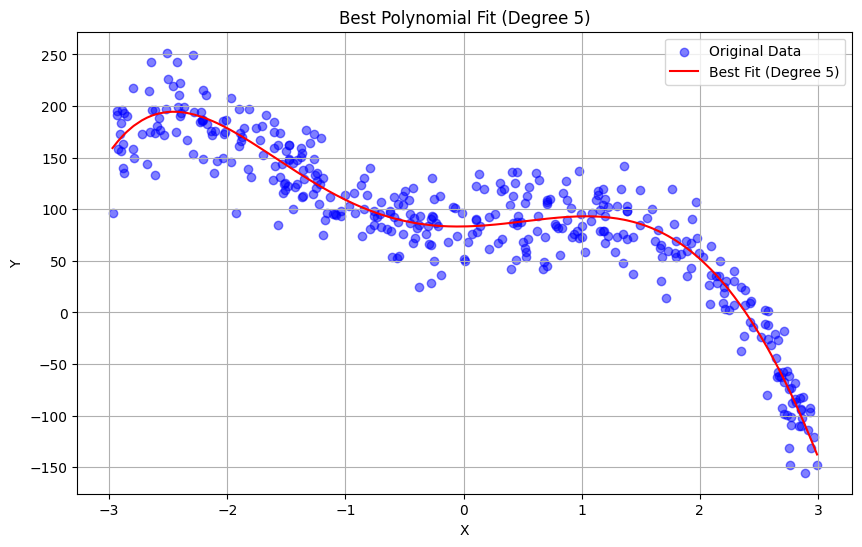

In [16]:
# Load data
data = pd.read_csv('train.csv')

# Manual split of data into training and validation sets
np.random.seed(42)  # for reproducibility
mask = np.random.rand(len(data)) < 0.9
train_data = data[mask]
val_data = data[~mask]

# Function to calculate R-squared
def calculate_r2(data, beta):
    X = data['x'].values
    Y = data['y'].values
    X_poly = np.column_stack([X**i for i in range(len(beta))])
    Y_pred = np.dot(X_poly, beta)
    SS_res = np.sum((Y - Y_pred)**2)
    SS_tot = np.sum((Y - np.mean(Y))**2)
    return 1 - (SS_res / SS_tot)

# Calculate Beta and R-squared for degrees 1 to 10
results = []
for m in range(1, 11):
    beta = higher_order_regression(train_data, m)
    r2_train = calculate_r2(train_data, beta)
    r2_val = calculate_r2(val_data, beta)
    results.append((m, r2_train, r2_val))

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Degree', 'R2_Train', 'R2_Val'])

# Find the degree that maximizes R2 on the validation set
best_degree = results_df.loc[results_df['R2_Val'].idxmax(), 'Degree']

print(results_df)
print(f"\nBest degree based on validation R2: {best_degree}")

# Plot the best fit
best_beta = higher_order_regression(train_data, best_degree)
X_sorted = np.sort(data['x'].values)
X_poly = np.column_stack([X_sorted**i for i in range(len(best_beta))])
Y_pred = np.dot(X_poly, best_beta)

plt.figure(figsize=(10, 6))
plt.scatter(data['x'], data['y'], color='blue', alpha=0.5, label='Original Data')
plt.plot(X_sorted, Y_pred, color='red', label=f'Best Fit (Degree {best_degree})')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Best Polynomial Fit (Degree {best_degree})')
plt.legend()
plt.grid(True)
plt.show()

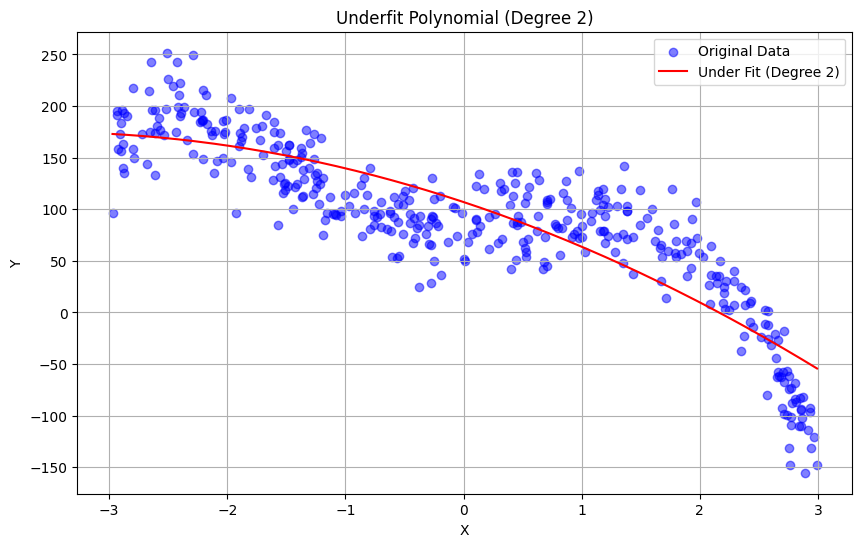

In [21]:
under_beta = higher_order_regression(train_data, 2)
X_sorted = np.sort(data['x'].values)
X_poly = np.column_stack([X_sorted**i for i in range(len(under_beta))])
Y_pred = np.dot(X_poly, under_beta)

plt.figure(figsize=(10, 6))
plt.scatter(data['x'], data['y'], color='blue', alpha=0.5, label='Original Data')
plt.plot(X_sorted, Y_pred, color='red', label=f'Under Fit (Degree {2})')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Underfit Polynomial (Degree {2})')
plt.legend()
plt.grid(True)
plt.show()

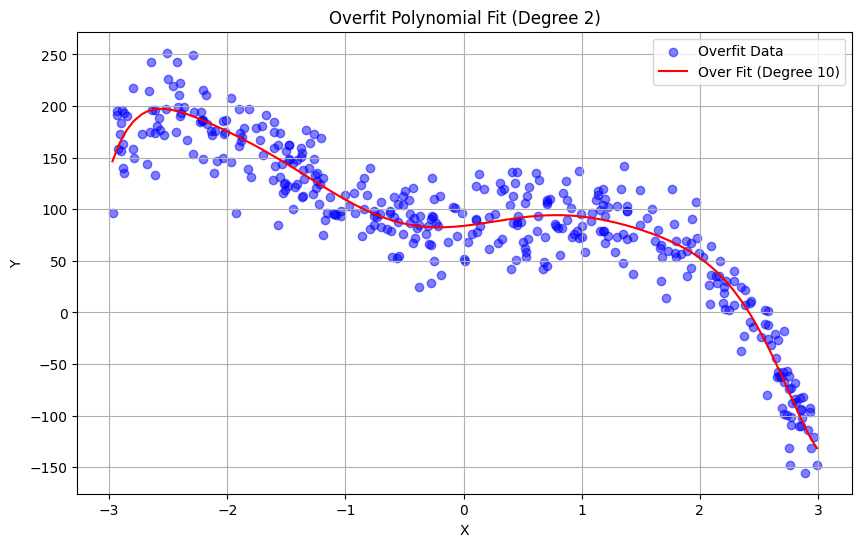

In [20]:
over_beta = higher_order_regression(train_data, 10)
X_sorted = np.sort(data['x'].values)
X_poly = np.column_stack([X_sorted**i for i in range(len(over_beta))])
Y_pred = np.dot(X_poly, over_beta)

plt.figure(figsize=(10, 6))
plt.scatter(data['x'], data['y'], color='blue', alpha=0.5, label='Overfit Data')
plt.plot(X_sorted, Y_pred, color='red', label=f'Over Fit (Degree {})')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Overfit Polynomial Fit (Degree {2})')
plt.legend()
plt.grid(True)
plt.show()